In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import keras
import matplotlib.dates as mdate
from matplotlib.dates import DateFormatter
from pandas.plotting import lag_plot
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from keras.callbacks import EarlyStopping
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error
#from ipynb.fs.full.Analysis import plot_moving_average #function from Analysis.ipynb file
#Using ADFtest for stationarity test
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

#Load data frame
# file_name_before = 'Bitcoin_before_trading_clean.csv'
# df_before_trading = pd.DataFrame(pd.read_csv(file_name_before))

file_name_after = 'Binance_after_trading_clean.csv'
df_after_trading = pd.DataFrame(pd.read_csv(file_name_after))

# Auto-ARIMA model (For data that volume is 0)

In [52]:
#before implementing the Auto-ARIMA model, we need to do a stationarity test

#if the p-value is greater than the significance level of 0.05, and ADF statistic is higher than any
#of the critical values, then this series is non-stationary
#Otherwise, if the p-value < 0.05 and ADF statistic < critical values, then  this will be stationary

#The two method will get the exact same answer

#Method 1
# series_close = df_after_trading['Close']
# result = adfuller(series_close, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'n_lags: {result[1]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')   



#Method 2
#series1 = np.random.randn(100)
# result = adfuller(series_close, autolag='AIC')
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')
# for key, value in result[4].items():
#     print('Critial Values:')
#     print(f'   {key}, {value}')


#If the series is non-stationary, then we are going to use 'I' FROM the ARIMA
#And in the model, it is defined as d
#Also, the reason why we need to use ARIMA is becasue of our series is non-stationary

#If the series is stationary, then straightly use ARMA(p,q) would be better

In [46]:
def check_stationary(series):
    result = adfuller(series, autolag='AIC')
    ADF_vs_criticalVal = True
    for key, value in result[4].items():
        if result[0] > value:
            ADF_vs_criticalVal = True
            ADF_vs_criticalVal=  ADF_vs_criticalVal * ADF_vs_criticalVal
        else:
            ADF_vs_criticalVal = False
    
    
    if (float(result[1]) > 0.05) & (ADF_vs_criticalVal == True):
        print('This series of data is non-stationary')

                
        
def plot_single_feature(timeseries):
    fig = plt.figure(figsize=(12,6))
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('USD')
    plt.plot(timeseries)
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    
    
#Check the lag plot
def plot_lag_feature(timeseries):
    fig, axes = plt.subplots(3,2,figsize = (8,12))
    fig.tight_layout()
    plt.title('autocorrelation plot')
    idcs = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

    for lag, axis_coords in enumerate(idcs, 1):
        row, col = axis_coords
        axis = axes[row][col]
        lag_plot(timeseries, lag = lag, ax = axis)
        axis.set_title(f"Lag={lag}")


In [4]:
#Fitting model
#start_p: Starting value of p in stepwise procedure.
#max_p: Maximum value of p
#start_q: Starting value of q in stepwise procedure.
#max_q: Maximum value of q
#start_P: Starting value of P in stepwise procedure.
#max_P:
#start_Q: Starting value of Q in stepwise procedure.
#max_Q:
#m: number of periods in each season
#p is the AR order and q is the MA order


def sorted_auto_arima(df_name):    
    #model set up
    ARIMA_df = df_name.sort_index(ascending= True, axis = 0)
    stop_point = int(0.75*len(ARIMA_df))
    train = ARIMA_df[: stop_point]
    test = ARIMA_df[stop_point :]
    
    train['Date'] = pd.to_datetime(train['Date'])
    test['Date'] = pd.to_datetime(test['Date'])

    
    #Visualize closing price
    ARIMA_df.index = ARIMA_df.Date
    ARIMA_df['Date'] = pd.to_datetime(ARIMA_df['Date'])
    
    train_close = train['Close'] #len 182
    test_close = test['Close'] #len 59

    size = len(df_name)

    model = auto_arima(train_close, start_p = 0, max_p = 3, start_q = 0, max_q = 3,test = 'adf',
                       m = 1, start_P = 0, seasonal = True, d = 1, max_D = 5,stepwise = True,
                       trace=True, error_action='ignore', suppress_warnings=True)

    model.fit(train_close)

    prediction = model.predict(n_periods = len(test_close))
    prediction = pd.DataFrame(prediction, index = test_close.index, columns=['Predictions'])

    
    plt.plot(train['Date'], train_close, label = 'train_close', color = 'blue')
    plt.plot(test['Date'],test_close, label = 'test_close', color = 'red')
    plt.plot(test['Date'], prediction, label = 'prediction', color = 'green')
    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    plt.gca().xaxis.set_major_locator(mdate.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    plt.legend()

    rmse = sqrt(mean_squared_error(test_close, prediction))
    print(rmse)
    
    return ARIMA_df

<ipython-input-4-c4ec7f6c4607>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
<ipython-input-4-c4ec7f6c4607>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2480.890, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2481.961, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2481.975, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2479.153, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2483.929, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.572 seconds
48.771799259619165


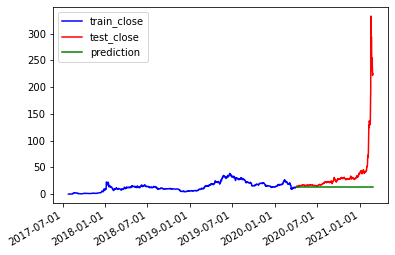

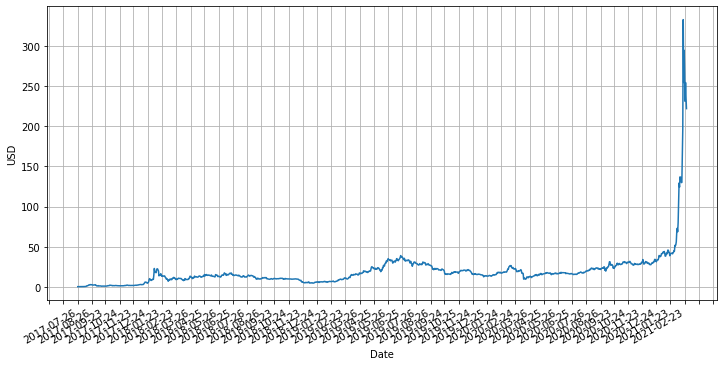

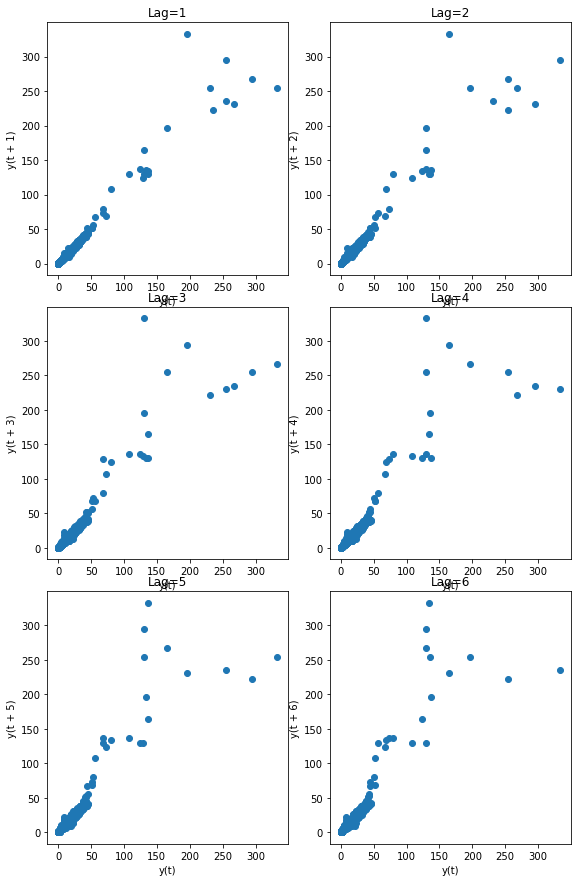

In [51]:
arima_df_sorted_before = sorted_auto_arima(df_after_trading)
plot_single_feature(arima_df_sorted_before['Open'])
plot_lag_feature(arima_df_sorted_before['Open'])

# LSTM

In [ ]:
#In this section, we use Date as index to predict the close price
#The first trial was to use the sorted order and divided them by 75%
#and 25% to training and testing set. But the RMSE and MAE are too high

#The second trial was to first having X and y, which X is a [[]] and the inner [] contains 60
#data, and its corresponding y contains only one data so it is []. 
#Then we turn them into array and shuffle them; and we can finally separate them into
#x_train and y_train for 75% on bot x_shuffle and y_shuffle

In [ ]:
def get_univariate_df(df_name):
    univariate_df = pd.DataFrame(index = range(0,len(df_name)), columns = ['Date', 'Close'])
    for i in range(0, len(df_before_trading)):
        univariate_df['Date'][i] = df_name['Date'][i]
        univariate_df['Close'][i] = df_name['Close'][i]
    return univariate_df


#When use the function below, if you want to use early stopping, choose yes, choose no
#then not use early stopping
early_stopping_no = 'no'
early_stopping_yes = 'yes'

# LSTM (Univariate, Sorted model)

In [ ]:
#This block of code is for sorted data (new_data_before only)
def LSTM_sorted_univariate(df_name, epochs, batch_size, learning_rate, early_stopping_or_not):
    if df_name.isnull().sum().all()>0:
        df_name = df_name.dropna()
    #Set up index
    univariate_df = pd.DataFrame(data = df_name, columns = ['Date', 'Close'])
    univariate_df.index = univariate_df.Date
    univariate_df.drop('Date', axis = 1, inplace = True) #inplace make sure we overwrite the original new_data
    
    #train,test split
    data_set = univariate_df.values
    training = data_set[: int(0.75 * len(df_name))]
    testing = data_set[int(0.75 * len(df_name)) :]

    #converting dataset into x_train and y_train
    scaler= MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data_set)

    X_train, y_train = [], []
    for i in range(60, len(training)):
        X_train.append(scaled_data[i-60 :i , 0])
        y_train.append(scaled_data[i,0])

    X_train= np.array(X_train)
    y_train = np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


    #single layer with 2 dense layer
    model = Sequential()
    model.add(LSTM(units = 300, return_sequences = False, input_shape = (X_train.shape[1],1)))
    model.add(Dense(64))
    model.add(Dense(1, input_dim = 1))



    #Adjusting learning rate here
    opt = Adam(learning_rate= learning_rate)

    
    #Compile and fit (add early stopping to find the optimal epochs)
    model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])
    if early_stopping_or_not.lower() == 'yes':
        earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',
                                            patience = 5, verbose = 1, restore_best_weights = True,
                                            min_delta=1e-4)
        history = model.fit(X_train, y_train, epochs = epochs, 
                    batch_size = batch_size, verbose = 1, 
                   callbacks = [earlystopping],
                   validation_split=0.3)
    else:
        history = model.fit(X_train, y_train, epochs = epochs, 
                        batch_size = batch_size, verbose = 1, 
                       validation_split=0.3)


    #Prediction and test
    sorted_input= univariate_df[len(univariate_df) - len(testing) - 60 :].values
    sorted_input = sorted_input.reshape(-1,1)
    sorted_input = scaler.transform(sorted_input) #using the same scaler as above

    X_test, y_test = [],[]
    for i in range(60, sorted_input.shape[0]):
        X_test.append(sorted_input[i-60 : i, 0])
        y_test.append(sorted_input[i,0])
    X_test = np.array(X_test)
    y_test= np.array(y_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (-1,1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    y_test = scaler.inverse_transform(y_test)

    #RMSE
    RMSE = np.sqrt(mean_squared_error(closing_price, testing))


    #MAE
    MAE =mean_absolute_error(closing_price, testing)


    #Plot comparision
    plot_train_new = univariate_df [: int(0.75 * len(univariate_df))]
    plot_test_new = univariate_df [int(0.75 * len(univariate_df)) :]
    plot_test_new['Predictions'] = closing_price
    plt.plot(plot_train_new['Close'])
    plt.plot(plot_test_new['Close'])
    plt.plot(plot_test_new[['Close', 'Predictions']])


    #Fit history
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])


    #Print RMSE and MAE
    print('The RMSE is: ', RMSE)
    print('The MAE is: ', MAE)


    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test, closing_price)/ y_test))) * 100
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test, closing_price)/ y_test)) ) * 100
    print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')
    
    model.summary()

In [ ]:
#Sorted date,  univariate,0 volume
univarLSTM_sorted_epochs_before = 300
univarLSTM_sorted_batch_size_before = 128
univarLSTM_sorted_df_before = get_univariate_df(df_before_trading)
yy = LSTM_sorted_univariate(univarLSTM_sorted_df_before , univarLSTM_sorted_epochs_before , univarLSTM_sorted_batch_size_before, 0.0001, early_stopping_no)

In [ ]:
#Sorted date,  univariate, not 0 volume
univarLSTM_sorted_epochs_after = 100
univarLSTM_sorted_batch_size_after = 128
univarLSTM_sorted_df_after = get_univariate_df(df_after_trading)
xx = LSTM_sorted_univariate(univarLSTM_sorted_df_after, univarLSTM_sorted_epochs_after, univarLSTM_sorted_batch_size_after, 0.0001, early_stopping_yes)

# LSTM(Univariate, shuffled model)

In [ ]:
def LSTM_shuffled_univariate(df_name, epochs, batch_size, learning_rate,early_stopping_or_not):
    if df_name.isnull().sum().all()>0:
        df_name = df_name.dropna()
    
    univariate_df = pd.DataFrame(data = df_name, columns = ['Date', 'Close'])
    univariate_df.index = univariate_df.Date
    univariate_df.drop('Date', axis = 1, inplace = True) #inplace make sure we overwrite the original new_data

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(univariate_df )
    
    
    #Set up X and y
    X, y = [], []
    for i in range(60, len(univariate_df)):
        X.append(scaled_data[i-60 :i , 0])
        y.append(scaled_data[i,0])    
    X = np.array(X)
    y = np.array(y)
    shuffle = np.random.permutation(len(X))
    X_shuffled = X[shuffle]
    y_shuffled = y[shuffle]
    X_train = X_shuffled[:int(0.75*len(X_shuffled))]
    X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    y_train = y_shuffled[:int(0.75*len(y_shuffled))]
    
    
    #Initialize LSTM layers and fit model
    #Single LSTM layer with 1 dropout layer and 2 dense layers
    model = Sequential()
    model.add(LSTM(units = 300, return_sequences = False, input_shape = (X_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Dense(1, input_dim = 1))
    
    
    #Adjusting learning rate here
    opt = Adam(learning_rate= learning_rate)
    
    
    #Compile and fit
    model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])
    if early_stopping_or_not.lower() == 'yes':
        earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',
                                            patience = 5, verbose = 1, restore_best_weights = True,
                                            min_delta=1e-4)
        history = model.fit(X_train, y_train, epochs = epochs, 
                    batch_size = batch_size, verbose = 1, 
                   callbacks = [earlystopping],
                   validation_split=0.3)
    else:
        history = model.fit(X_train, y_train, epochs = epochs, 
                        batch_size = batch_size, verbose = 1, 
                       validation_split=0.3)
    
    
    
    #Prediction and test
    shuffled_input= univariate_df[len(univariate_df) - math.ceil(0.25*len(univariate_df)) - 60 :].values
    shuffled_input = shuffled_input.reshape(-1,1)
    shuffled_input = scaler.transform(shuffled_input) #using the same scaler as above

    
    

    #Get X_test and y_test
    X_test, y_test  = [],[]
    for i in range(60, shuffled_input.shape[0]):
        X_test.append(shuffled_input[i-60 : i, 0])
        y_test.append(shuffled_input[i,0])

    X_test  = np.array( X_test)
    y_test = np.array(y_test)
    X_test = np.reshape( X_test , (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (-1,1))
    closing_price = model.predict(X_test )

    closing_price = scaler.inverse_transform(closing_price)
    y_test = scaler.inverse_transform(y_test)
    
    
    #RMSE
    RMSE = np.sqrt(mean_squared_error(closing_price,y_test))


    #MAE
    MAE = mean_absolute_error(closing_price, y_test)
    
    
    #Plot comparision
    plot_train = univariate_df[: int(0.75 * len(univariate_df))]
    plot_test = univariate_df[int(0.75 * len(univariate_df)) :]

    plot_test['Predictions'] = closing_price
    plt.plot(plot_train['Close'])
    plt.plot(plot_test[['Close', 'Predictions']])
    
    
    #Fit history and history plot
    print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])

    
    
    #Print RMSE and MAE
    print('The RMSE is: ', RMSE)
    print('The MAE is: ', MAE)
    
    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test, closing_price)/ y_test))) * 100
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test, closing_price)/ y_test)) ) * 100
    print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')
    
    model.summary()

In [ ]:
#Shuffled date,  univariate, 0 volume
univarLSTM_shuffled_epochs_before = 300
univarLSTM_shuffled_batch_size_before = 200
univarLSTM_shuffled_df_before = get_univariate_df(df_before_trading)
LSTM_shuffled_univariate(univarLSTM_shuffled_df_before, univarLSTM_shuffled_epochs_before, univarLSTM_shuffled_batch_size_before, 0.0001, early_stopping_no)

In [ ]:
#Shuffled date, univariate, not 0 volume
univarLSTM_shuffled_epochs_after = 100
univarLSTM_shuffled_batch_size_after = 200
univarLSTM_shuffled_df_after = get_univariate_df(df_after_trading)
LSTM_shuffled_univariate(univarLSTM_shuffled_df_after, univarLSTM_shuffled_epochs_after, univarLSTM_shuffled_batch_size_after, 0.0001,early_stopping_yes)

# LSTM(Multivariate model, sorted date)

In [ ]:
def LSTM_sorted_multivariate(df_name, epochs, batch_size, learning_rate,early_stopping_or_not):
    #Index batches
    multivariate_df = df_name.sort_values(by = ['Date']).copy()
    multivariate_df['Date'] = pd.to_datetime( multivariate_df['Date'], format='%Y-%m-%d')

    #Save index
    date_index = multivariate_df.index
    date = pd.to_datetime(multivariate_df.index)

    #Separate day, month and Year into different columns
    multivariate_df['Year'] = multivariate_df['Date'].dt.year
    multivariate_df['Month'] = multivariate_df['Date'].dt.month
    multivariate_df['Day'] = multivariate_df['Date'].dt.day
    
    
    #Reset the index so that we can have the date-index to a number-index
    multivariate_df = multivariate_df.reset_index(drop = True).copy()

    
    FEATURES = ['High', 'Low', 'Open','Close', 'Volume' , 'Marketcap','Year', 'Month', 'Day']
    multivariate_df_new = pd.DataFrame(df_after_trading)
    multivariate_df_new = multivariate_df[FEATURES]
    
    
    #Reshape df
    nrows = multivariate_df.shape[0]
    multivariate_df_new = np.array(multivariate_df_new)
    multivariate_df_new = np.reshape(multivariate_df_new, (nrows, -1))
    
    
    #Transform data by scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(multivariate_df_new)

    
    #Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler(feature_range=(0,1))
    df_close = pd.DataFrame(df_name['Close'])
    close_scaled = scaler_pred.fit_transform(df_close)
    
    
    #Set up X_train and y_train
    sequence_length = 60
    train_data_len = math.ceil(scaled_data.shape[0] * 0.75)
    train_data = scaled_data[0:train_data_len, :]
    
    X_train, y_train = [], []
    for i in range(60, train_data_len):
        X_train.append(train_data[i-sequence_length:i, :])
        y_train.append(train_data[i, 0])
        
        
    #Convert X_train and y_train to np array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #Set up learning rate
    opt = keras.optimizers.Adam(learning_rate = learning_rate) #best 0.00001


    #Create test data
    test_data = scaled_data[train_data_len - sequence_length :, :]

    X_test, y_test = [], []
    test_data_len = test_data.shape[0]
    
    
    for i in range(sequence_length, test_data_len):
        X_test.append(test_data[i-sequence_length :i, :])
        y_test.append(test_data[i, 0])

    #Convert X_test and y_test to np array
    X_test, y_test = np.array(X_test), np.array(y_test)


    #Set up sequential model
    model = Sequential()
    model.add(LSTM(300, return_sequences=False, input_shape = (60,9)))
    model.add(Dense(128))
    model.add(Dense(1))

    
    #Compile and fit
    model.compile(optimizer = opt, loss='mean_squared_error', metrics=['accuracy'])
    
    if early_stopping_or_not.lower() == 'yes':
        earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',
                                            patience = 5, verbose = 1, restore_best_weights = True,
                                            min_delta=1e-4)
        history = model.fit(X_train, y_train, epochs = epochs, 
                    batch_size = batch_size, verbose = 1, 
                   callbacks = [earlystopping],
                   validation_split=0.3)
    else:
        history = model.fit(X_train, y_train, epochs = epochs, 
                        batch_size = batch_size, verbose = 1, 
                       validation_split=0.3)
        
    
    
    #Prediction
    prediction = model.predict(X_test)
    prediction = prediction.flatten()


    #RMSE
    RMSE = np.sqrt(mean_squared_error(prediction, y_test))

    #MAE
    MAE = mean_absolute_error(prediction, y_test)


    #Get predicted value
    plt.plot(y_test)
    plt.plot(prediction)


    #Print RMSE and MAE
    print('The RMSE is: ', RMSE)
    print('The MAE is: ', MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test, prediction)/ y_test))) * 100
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test, prediction)/ y_test)) ) * 100
    print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')
    
    model.summary()

In [ ]:
#sorted date, multivariate, 0 volume
sorted_multivarLSTM_epochs_before = 300
sorted_multivarLSTM_batch_size_before = 200
LSTM_sorted_multivariate(df_before_trading, sorted_multivarLSTM_epochs_before, sorted_multivarLSTM_batch_size_before, 0.0001, early_stopping_no)

In [ ]:
sorted_multivarLSTM_epochs_after = 100
sorted_multivarLSTM_batch_size_after = 200
LSTM_sorted_multivariate(df_after_trading, sorted_multivarLSTM_epochs_after,sorted_multivarLSTM_batch_size_after, 0.0001,early_stopping_yes)

In [ ]:
def LSTM_shuffled_multivariate(df_name, epochs, batch_size, learning_rate,early_stopping_or_not):
    #Index batches
    multivariate_df = df_name.sort_values(by = ['Date']).copy()
    multivariate_df['Date'] = pd.to_datetime( multivariate_df['Date'], format='%Y-%m-%d')

    #Save index
    date_index = multivariate_df.index
    date = pd.to_datetime(multivariate_df.index)

    #Separate day, month and Year into different columns
    multivariate_df['Year'] = multivariate_df['Date'].dt.year
    multivariate_df['Month'] = multivariate_df['Date'].dt.month
    multivariate_df['Day'] = multivariate_df['Date'].dt.day
    
    #Reset the index so that we can have the date-index to a number-index
    multivariate_df = multivariate_df.reset_index(drop = True).copy()

    
    FEATURES = ['High', 'Low', 'Open','Close', 'Volume' , 'Marketcap','Year', 'Month', 'Day']
    multivariate_df_new = pd.DataFrame(df_after_trading)
    multivariate_df_new = multivariate_df[FEATURES]
    
    
    #Reshape df
    nrows = multivariate_df.shape[0]
    multivariate_df_new = np.array(multivariate_df_new)
    multivariate_df_new = np.reshape(multivariate_df_new, (nrows, -1))
    
    
    #Transform data by scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(multivariate_df_new)

    
    #Creating a separate scaler that works on a single column for scaling predictions
    scaler_pred = MinMaxScaler(feature_range=(0,1))
    df_close = pd.DataFrame(df_name['Close'])
    close_scaled = scaler_pred.fit_transform(df_close)
    
    
    #Set up X_train and y_train
    sequence_length = 60
    train_data_len = math.ceil(scaled_data.shape[0] * 0.75)
    train_data = scaled_data[0:train_data_len, :]
    
    X_train, y_train = [], []
    for i in range(60, train_data_len):
        X_train.append(train_data[i-sequence_length:i, :])
        y_train.append(train_data[i, 0])
    
    
    #Convert X_train and y_train to np array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    
    #Shuffle data
    shuffle = np.random.permutation(len(X_train))
    X_train = X_train[shuffle]
    y_train = y_train[shuffle]
    
    
    #Set up learning rate
    opt = keras.optimizers.Adam(learning_rate = learning_rate) #best 0.00001


    #Create test data
    test_data = scaled_data[train_data_len - sequence_length :, :]

    X_test, y_test = [], []
    test_data_len = test_data.shape[0]
    
    
    for i in range(sequence_length, test_data_len):
        X_test.append(test_data[i-sequence_length :i, :])
        y_test.append(test_data[i, 0])

    #Convert X_test and y_test to np array
    X_test, y_test = np.array(X_test), np.array(y_test)


    #Set up sequential model
    model = Sequential()
    model.add(LSTM(300, return_sequences=False, input_shape = (60,9)))
    model.add(Dense(128))
    model.add(Dense(1))

    
    #Compile and fit
    model.compile(optimizer = opt, loss='mean_squared_error', metrics=['accuracy'])
    
    if early_stopping_or_not.lower() == 'yes':
        earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',
                                            patience = 5, verbose = 1, restore_best_weights = True,
                                            min_delta=1e-4)
        history = model.fit(X_train, y_train, epochs = epochs, 
                    batch_size = batch_size, verbose = 1, 
                   callbacks = [earlystopping],
                   validation_split=0.3)
    else:
        history = model.fit(X_train, y_train, epochs = epochs, 
                        batch_size = batch_size, verbose = 1, 
                       validation_split=0.3)
        

    
    
    #Prediction
    prediction = model.predict(X_test)
    prediction = prediction.flatten()


    #RMSE
    RMSE = np.sqrt(mean_squared_error(prediction, y_test))

    #MAE
    MAE = mean_absolute_error(prediction, y_test)


    #Get predicted value
    plt.plot(y_test)
    plt.plot(prediction)


    #Print RMSE and MAE
    print('The RMSE is: ', RMSE)
    print('The MAE is: ', MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test, prediction)/ y_test))) * 100
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test, prediction)/ y_test)) ) * 100
    print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')
    
    model.summary()

In [ ]:
#shuffled date, multivariate, 0 volume
shuffled_multivarLSTM_epochs_before = 200
shuffled_multivarLSTM_batch_size_before = 200
LSTM_shuffled_multivariate(df_before_trading, shuffled_multivarLSTM_epochs_before, shuffled_multivarLSTM_batch_size_before, 0.0001,early_stopping_no)

In [ ]:
#shuffled date, multivariate, not 0 volume
shuffled_multivarLSTM_epochs_after = 100
shuffled_multivarLSTM_batch_size_after = 128
LSTM_shuffled_multivariate(df_after_trading, shuffled_multivarLSTM_epochs_after, shuffled_multivarLSTM_batch_size_after, 0.0001,early_stopping_yes)